# PyMC Wrapper Example Walkthrough

For the case of this example, we want to get an early read on how quickly our userbase will upgrade to a new version of our application. We have released updates in the past, and so our plan is to use prior adoption curves to generate priors. From there, we update that model with real observations as they happen and update our estimates accordingly. 

## Library Imports

In [37]:
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import arviz as az
from pprint import pprint
from functools import partial
from copy import deepcopy

In [2]:
%load_ext autoreload 
%autoreload 1

In [3]:
!pip install ..

Processing d:\projects\pymc-wrapper
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for PyMC-Wrapper: filename=PyMC_Wrapper-1.0-py3-none-any.whl size=4356 sha256=008fa7b3ff912b7ba9ceaea2701d890d3f950094f20ad2ba902c981515cd3c12
  Stored in directory: c:\users\matthew burke\appdata\local\pip\cache\wheels\a5\11\a2\b36de191122bd1284ecd6927f5e9b94ca0861f2a1da468b89b
Successfully built PyMC-Wrapper
  Attempting uninstall: PyMC-Wrapper
    Found existing installation: PyMC-Wrapper 1.0
    Uninstalling PyMC-Wrapper-1.0:
      Successfully uninstalled PyMC-Wrapper-1.0


In [4]:
from pymc_wrapper.model import PymcModel
from pymc_wrapper.utils import load_config_from_file

## Generate Example Data

We create synthetic data using the CDF of the exponential function to simulate full adoption of users to the new version releases. We additionally add some noise and decrease the strength of the noise over time as the cohorts mature. Each release has a slightly different adoption rate (`lambda` parameter), but they all follow the same distribution. 

In [5]:
def negative_exponential(week, lambda_val, intercept):
    return 1 - intercept - (1 - intercept) * np.exp(-lambda_val * week)

In [6]:
def generate_release_data(X, num_periods, base_lambda_val, noise_frac, noise_strength, max_intercept):
    intercept = np.random.random() * max_intercept
    lambda_val = base_lambda_val + (np.random.random() - 0.5) * lambda_noise_frac 
    
    Y = np.clip(negative_exponential(X, lambda_val, intercept) + np.random.random(num_periods) * noise_frac * noise_strength ** X, 0, 1)
    return Y

In [7]:
independent_var = 'week'
dependent_var = 'adoption_rate'

In [8]:
num_releases = 5
num_periods = 52

base_lambda_val = 0.08
lambda_noise_frac = 0.04
noise_frac = 0.1
noise_strength = 0.93
max_intercept = 0.1

In [9]:
release_data = []
for i in range(num_releases):
    X = np.arange(num_periods)
    Y = generate_release_data(X, num_periods, base_lambda_val, noise_frac, noise_strength, max_intercept)
    df = pd.DataFrame({independent_var: X, dependent_var: Y, 'release': i})
    release_data.append(df)

df = pd.concat(release_data)

<AxesSubplot: xlabel='week', ylabel='adoption_rate'>

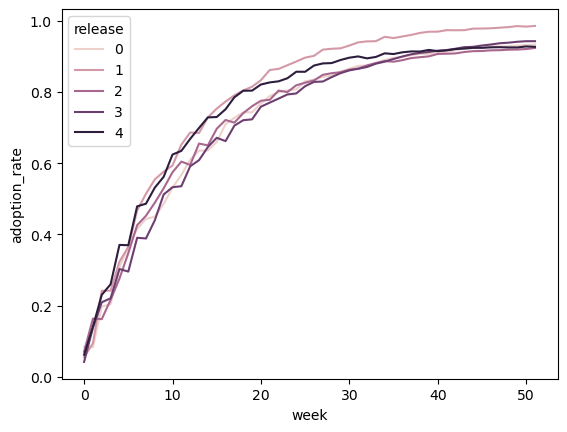

In [10]:
sns.lineplot(data=df, x=independent_var, y=dependent_var, hue='release')

## Train A Basic Model

### Loading/Creating the Model Config

We pre-defined a YAML file with most of what we need to create our PyMC Wrapper model object. We can load it with a utility function

In [11]:
config_file_path = 'example_config.yaml'

In [12]:
config = load_config_from_file(config_file_path)

The components of the model include the following:
- `indedependent_vars`
    - A list of column names in a dataframe that contain the independent variable data
- `variable_params`
    - A list of variable definitions that we want to infer using our model listed by name
        - `params`; The name and any input variables that belong to the distribution
        - `dist` The case sensitive name of the PyMC distribution that we will use to model this variable
- `sample_params`: Any parameters we want to pass into our sampling inference. 


The last thing we have to do before model creation is to add the function to map our independent variables and model variables to the dependent variable.

In [13]:
config['function_params'] = {
    'function': negative_exponential
}

In [14]:
pprint(config)

{'function_params': {'function': <function negative_exponential at 0x000002205A7F1120>},
 'independent_vars': ['week'],
 'sample_params': {'draws': 1000},
 'variable_params': {'intercept': {'dist': <class 'pymc.distributions.continuous.Normal'>,
                                   'params': {'mu': 0,
                                              'name': 'intercept',
                                              'sigma': 1}},
                     'lambda_val': {'dist': <class 'pymc.distributions.continuous.HalfNormal'>,
                                    'params': {'name': 'lambda_val',
                                               'sigma': 1}}}}


## Model Training

Here, we walk through creating a `PymcModel` object from our config file, and then train it our release adoption data. We then do some quick plots to confirm it's fitting correctly and generating credible intervals. 

In [15]:
model = PymcModel(config) 

In [16]:
X = df[[independent_var]]
Y = df[dependent_var]
model.fit(X, Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


For any detailed PyMC training analysis, we still have access to the trace and can perform our usual checks.

array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'lambda_val'}>,
        <AxesSubplot: title={'center': 'lambda_val'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

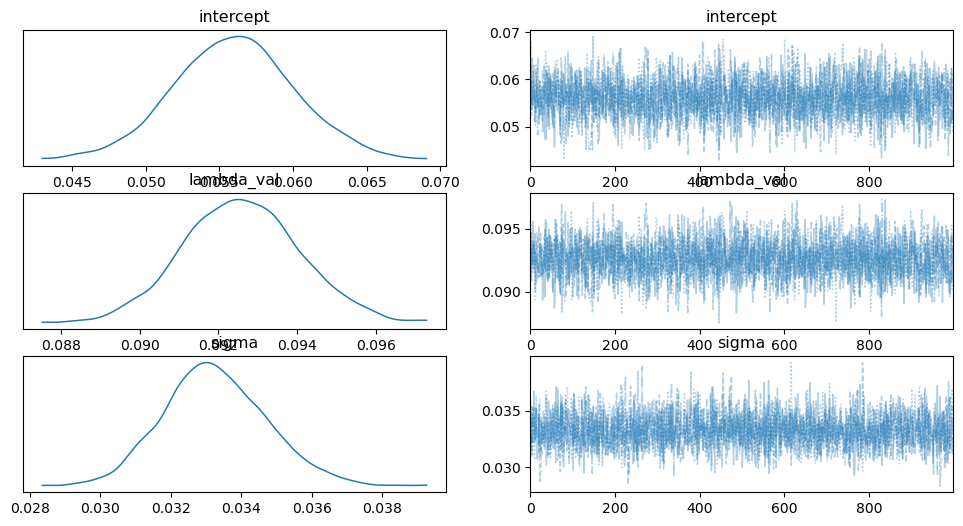

In [17]:
az.plot_trace(model.trace, combined=True)

We can test our prediction on "out-of-sample" data, meaning just predicting forward in time given our current data and no new additional observations. This will let us visualize our learned distribution alongside the original values.

In [18]:
test_X = pd.DataFrame({'week': np.arange(52)})

Once the model completes training, the model wrapper uses the mean values of each parameter by sampling the posterior distribution, and it generates a function that can output predictions without having to do any additional sampling. For many cases, this should speed up prediction time significantly. 

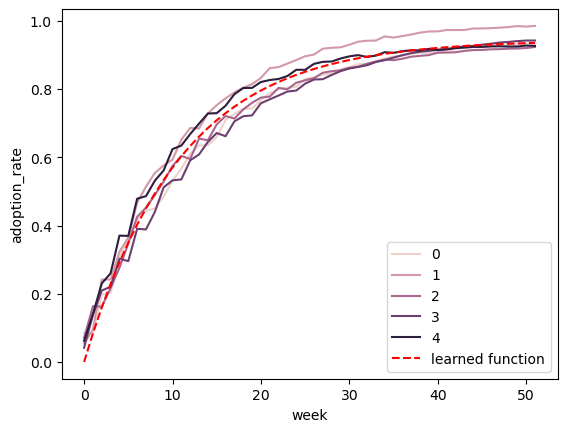

In [19]:
sns.lineplot(data=df, x=independent_var, y=dependent_var, hue='release')
plt.plot(model.predict(test_X), label='learned function', color='r', linestyle='dashed')
plt.legend()

By passing in an alpha parameter, we skip using the pre-defined function we made before and sample from our posterior to generate new mean predictions along with upper/lower bounds of the credible interval based on the alpha we chose.

In [20]:
cred_ints = model.predict(test_X, alpha=0.9)

Sampling: [Y_obs]


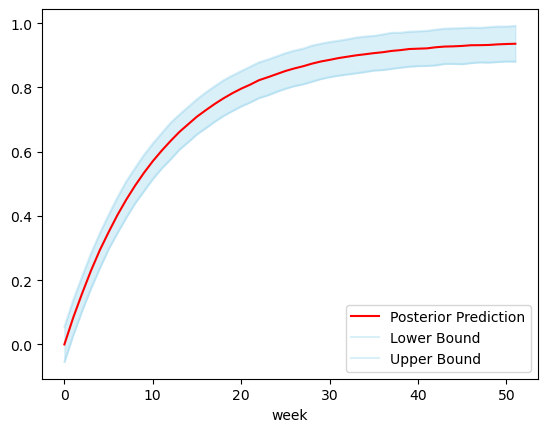

In [21]:
fig = plt.figure()
a=sns.lineplot(x=test_X[independent_var], y=cred_ints[1, :], label='Posterior Prediction', color='red')
b=sns.lineplot(x=test_X[independent_var], y=cred_ints[0, :], label='Lower Bound', color='skyblue', alpha=.3)
c=sns.lineplot(x=test_X[independent_var], y=cred_ints[2, :], label='Upper Bound', color='skyblue', alpha=.3)
line = c.get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='skyblue', alpha=.3)
plt.legend()

## Exploring Potential Use Cases

### Saving and Loading Our Model

Here, we will first save our model trace, create a new model object using our config and reload the trace so it's ready for prediction.

In [22]:
trace_file_path = 'trace.pkl'

model.save_trace(trace_file_path)

In [23]:
new_model = PymcModel(config)
new_model.load_trace(trace_file_path)

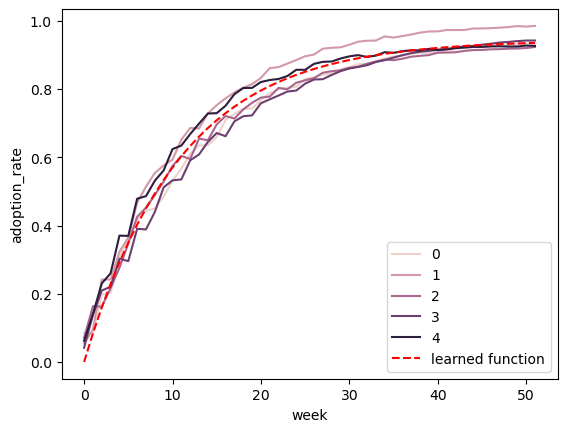

In [24]:
# Confirm we have the same results as before
sns.lineplot(data=df, x=independent_var, y=dependent_var, hue='release')
plt.plot(new_model.predict(test_X), label='learned function', color='r', linestyle='dashed')
plt.legend()

### Exporting Our Config

In some cases, we may want to not use our trained trace directly for a new model but still want to incorporate our learnings from existing models. The `export_trained_config` function takes the trained variable averages and replaces the original config file priors with the posterior values. We can pass this config into a new model for an opinionated starting point, rather than from an uninformative baseline, or do so but relax the variation on the priors to allow it to be influenced more by observations. 

Please note that this only supports the `Normal` and `HalfNormal` distributions right now, as the parameter inputs for different distributions are varied, and this project is just a POC at this point. 

In [78]:
trained_config_file_path = 'example_trained_config.yaml'

model.export_trained_config(trained_config_file_path)

In [83]:
trained_config = load_config_from_file(trained_config_file_path)

trained_config['function_params'] = {
    'function': negative_exponential
}

In [84]:
pprint(trained_config)

{'function_params': {'function': <function negative_exponential at 0x000002205A7F1120>},
 'independent_vars': ['week'],
 'sample_params': {'draws': 1000},
 'variable_params': {'intercept': {'dist': <class 'pymc.distributions.continuous.Normal'>,
                                   'params': {'mu': 0.09052028965984911,
                                              'name': 'intercept',
                                              'sigma': 0.00998416579006974}},
                     'lambda_val': {'dist': <class 'pymc.distributions.continuous.HalfNormal'>,
                                    'params': {'name': 'lambda_val',
                                               'sigma': 0.8406296371105827}}}}


### Updating New Release Predictions

Our goal for this project is to predict what our adoption rate of our new release will look like over the upcoming year. 

From there, we should be able to update this model using out `fit` function as we accrue more data, and visualize our updated prediction as time progresses.

In [85]:
X = np.arange(num_periods)
Y = generate_release_data(X, num_periods, 0.06, noise_frac, noise_strength, max_intercept)
df = pd.DataFrame({independent_var: X, dependent_var: Y})

In [86]:
update_model = PymcModel(trained_config)

In [87]:
num_periods_update = 4
num_iterations = num_periods // num_periods_update - 1

In [96]:
chart_data_list = []

for i in range(num_iterations):
    
    
    historical_indices = np.arange(0, (i + 1) * num_periods_update)
    prediction_indices = np.arange((i + 1) * num_periods_update, num_periods)
    
    temp_df = df.iloc[0:(i + 1) * num_periods_update]
    model.fit(temp_df, temp_df[dependent_var])
    
    chart_data_list.append({
        'historical_indices': historical_indices,
        'prediction_indices': prediction_indices,
        'historical_data': df[dependent_var][historical_indices].values,
        'prediction': model.predict(df.iloc[prediction_indices])
    })


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_val, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


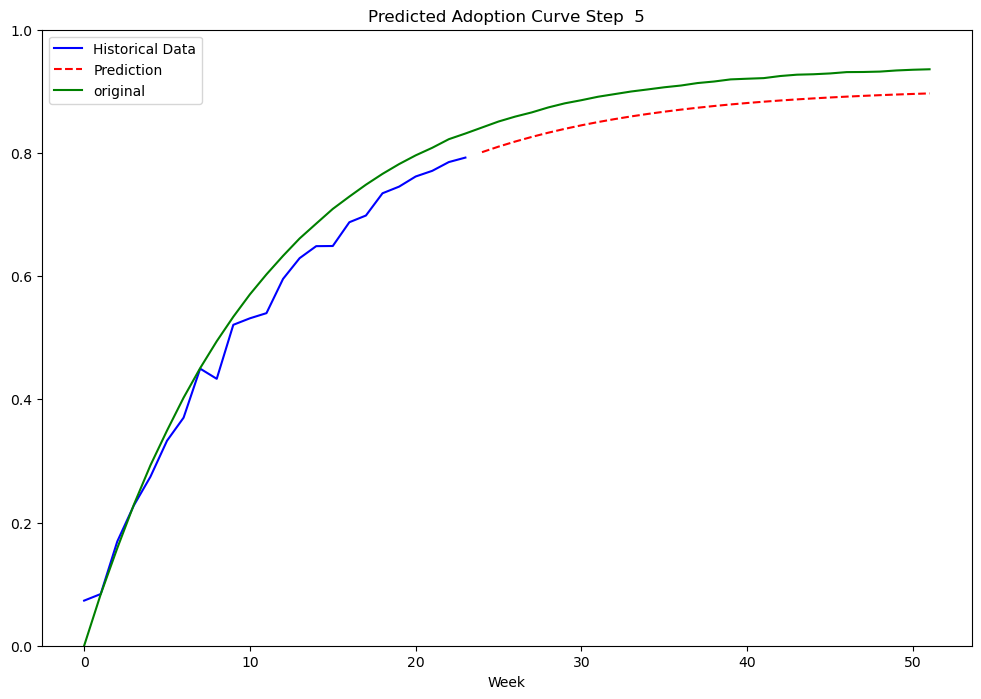

In [129]:



fig, ax = plt.subplots(figsize=(12, 8))

def draw_iteration(i):
    
    ax.clear()
    ax.set_ylim(0, 1)

    p1 = ax.plot(
        chart_data_list[i]['historical_indices'], 
        chart_data_list[i]['historical_data'],
        color='b',
        label='Historical Data'
    )
    p2= ax.plot(
        chart_data_list[i]['prediction_indices'], 
        chart_data_list[i]['prediction'],
        color='r',
        linestyle='dashed',
        label='Prediction'
    )

    ax.set_xlabel('Week')
    plt.title('Predicted Adoption Curve Step {:2d}'.format(i))
    plt.legend(loc='lower right')


draw_iteration(5)
plt.plot(test_X[independent_var], cred_ints[1, :], label='original', color='g')
plt.legend()

In [155]:
%matplotlib nbagg

In [165]:
outfile = 'monthly_update.gif'
    
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(12, 8))

def draw_iteration(i):
    
    ax.clear()
    ax.set_ylim(0, 1)

    p1 = ax.plot(
        chart_data_list[i]['historical_indices'], 
        chart_data_list[i]['historical_data'],
        color='b',
        label='Historical Data'
    )
    p2= ax.plot(
        chart_data_list[i]['prediction_indices'], 
        chart_data_list[i]['prediction'],
        color='r',
        linestyle='dashed',
        label='Prediction'
    )

    ax.set_xlabel('Week')
    plt.title('Predicted Adoption Curve: {:2d}-{:2d} weeks'.format(i * 4 + 1, i * 4 + 3 + 1))
    plt.legend(loc='lower right')

animator = animation.FuncAnimation(fig, draw_iteration, frames=num_iterations, interval=1000, repeat=True)

animator.save(outfile, dpi=80, writer='Pillow')
# animator.save(outfile, fps=60, extra_args=['-vcodec', 'libx264'])